In [1391]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno

import plotly.graph_objects as go

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error


In [1392]:
#setting options to be able to see whole text in dataframe columns
pd.set_option("display.max_rows", None, "display.max_columns", None)
pd.set_option('max_colwidth',800)

### EDA on Covid surveillance data

In [1393]:
df_surv=pd.read_csv('../data/covid_surveillance.csv')

In [1394]:
df_surv.head()

,case_month,res_state,state_fips_code,res_county,county_fips_code,age_group,sex,race,ethnicity,case_positive_specimen,process,exposure_yn,current_status,symptom_status,hosp_yn,icu_yn,death_yn,case_onset_interval,underlying_conditions_yn
0,2022-05,KY,21,JEFFERSON,21111.0,65+ years,Female,White,Non-Hispanic/Latino,0.0,Missing,Missing,Probable Case,Missing,No,Missing,No,NaN,NaN
1,2022-01,WI,55,RACINE,55101.0,50 to 64 years,Male,White,Non-Hispanic/Latino,NaN,Missing,Missing,Laboratory-confirmed case,Missing,Unknown,Missing,Unknown,NaN,NaN
2,2022-01,LA,22,CADDO,22017.0,18 to 49 years,Female,Unknown,Unknown,0.0,Missing,Missing,Laboratory-confirmed case,Unknown,Unknown,Unknown,Missing,NaN,NaN
3,2021-04,FL,12,LEE,12071.0,18 to 49 years,Female,NaN,NaN,-10.0,Missing,Missing,Laboratory-confirmed case,Symptomatic,No,Missing,No,0.0,NaN
4,2021-08,NC,37,NEW HANOVER,37129.0,0 - 17 years,Female,White,Hispanic/Latino,0.0,Missing,Unknown,Probable Case,Symptomatic,No,Unknown,No,0.0,NaN


In [1395]:
df_surv.shape

(500000, 19)

In [1396]:
df_surv.isnull().sum()

case_month                       0
res_state                        0
state_fips_code                  0
res_county                     871
county_fips_code               871
age_group                     3024
sex                           7959
race                         64748
ethnicity                    75698
case_positive_specimen      270451
process                          0
exposure_yn                      0
current_status                   0
symptom_status                   0
hosp_yn                          0
icu_yn                           0
death_yn                     18368
case_onset_interval         291941
underlying_conditions_yn    483518
dtype: int64

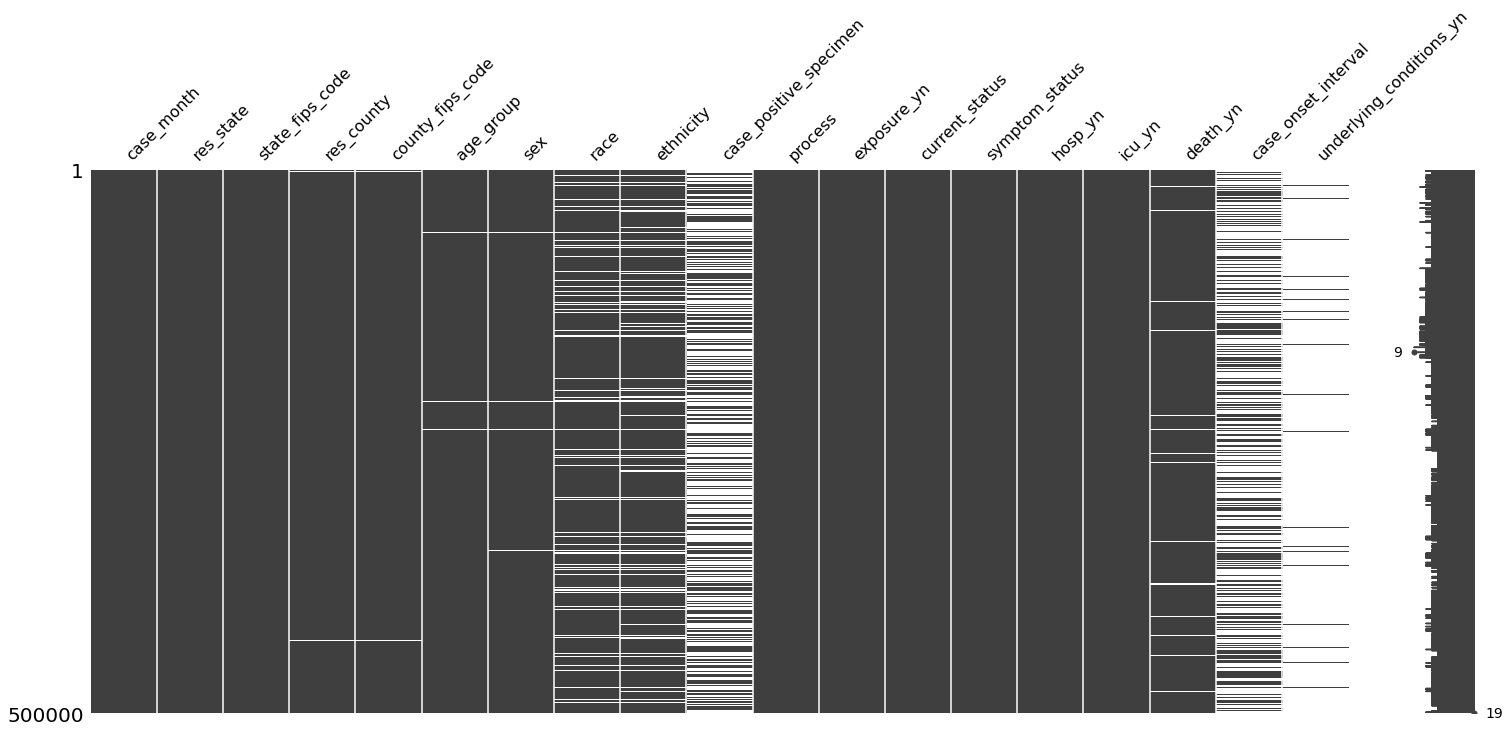

In [1397]:
msno.matrix(df_surv);

The figure above shows null values across the data sets. Seems like 'case_positive_specimen', case_onset_interval' and 'underlying_conditions_yn' have lots of null values.

In [1398]:
# Dropping state_fips_code, county_fips_code, and columns with a lot of null values
df_surv.drop(columns=['state_fips_code', 'county_fips_code', 'case_positive_specimen','case_onset_interval','underlying_conditions_yn'], inplace=True)

In [1399]:
df_surv.isnull().sum();

In [1400]:
#no. of states in the dataset
len(df_surv['res_state'].unique())

49

The file contains data from 49 states

In [1401]:
df_surv.head()

,case_month,res_state,res_county,age_group,sex,race,ethnicity,process,exposure_yn,current_status,symptom_status,hosp_yn,icu_yn,death_yn
0,2022-05,KY,JEFFERSON,65+ years,Female,White,Non-Hispanic/Latino,Missing,Missing,Probable Case,Missing,No,Missing,No
1,2022-01,WI,RACINE,50 to 64 years,Male,White,Non-Hispanic/Latino,Missing,Missing,Laboratory-confirmed case,Missing,Unknown,Missing,Unknown
2,2022-01,LA,CADDO,18 to 49 years,Female,Unknown,Unknown,Missing,Missing,Laboratory-confirmed case,Unknown,Unknown,Unknown,Missing
3,2021-04,FL,LEE,18 to 49 years,Female,NaN,NaN,Missing,Missing,Laboratory-confirmed case,Symptomatic,No,Missing,No
4,2021-08,NC,NEW HANOVER,0 - 17 years,Female,White,Hispanic/Latino,Missing,Unknown,Probable Case,Symptomatic,No,Unknown,No


In [1402]:
df_surv.dtypes

case_month        object
res_state         object
res_county        object
age_group         object
sex               object
race              object
ethnicity         object
process           object
exposure_yn       object
current_status    object
symptom_status    object
hosp_yn           object
icu_yn            object
death_yn          object
dtype: object

**Checking values for each column of interest**

In [1403]:
df_surv['current_status'].value_counts()

Laboratory-confirmed case    413088
Probable Case                 86912
Name: current_status, dtype: int64

In [1404]:
df_surv['age_group'].value_counts()

18 to 49 years    260410
50 to 64 years     89260
0 - 17 years       79883
65+ years          62161
Missing             5262
Name: age_group, dtype: int64

In [1405]:
df_surv['ethnicity'].value_counts()

Non-Hispanic/Latino    269710
Unknown                 87237
Hispanic/Latino         34103
Missing                 33252
Name: ethnicity, dtype: int64

In [1406]:
df_surv['race'].value_counts()

White                                     268251
Unknown                                    62907
Black                                      49195
Missing                                    36247
Asian                                       7746
Multiple/Other                              7063
American Indian/Alaska Native               3684
Native Hawaiian/Other Pacific Islander       159
Name: race, dtype: int64

In [1407]:
df_surv['process'].value_counts()

Missing                            480591
Clinical evaluation                  9660
Laboratory reported                  4206
Routine surveillance                 1476
Unknown                              1234
Contact tracing of case patient      1008
Multiple                              960
Provider reported                     612
Other                                 251
Autopsy                                 2
Name: process, dtype: int64

In [1408]:
df_surv['exposure_yn'].value_counts()

Missing    465931
Yes         22616
Unknown     11453
Name: exposure_yn, dtype: int64

In [1409]:
df_surv['symptom_status'].value_counts()

Missing         238717
Symptomatic     195669
Unknown          60279
Asymptomatic      5335
Name: symptom_status, dtype: int64

In [1410]:
df_surv['hosp_yn'].value_counts()

Missing    222775
No         163411
Unknown     98627
Yes         15187
Name: hosp_yn, dtype: int64

In [1411]:
df_surv['icu_yn'].value_counts()

Missing    413879
Unknown     73333
No          11936
Yes           852
Name: icu_yn, dtype: int64

In [1412]:
df_surv['death_yn'].value_counts()

Missing    221094
No         177586
Unknown     81179
Yes          1773
Name: death_yn, dtype: int64

Some of the columns have a lot of 'Missing' and 'Unknown' values.  
We will drop the columns with more than 450,000 Missing/Unknown values.

In [1413]:
#dropping some more columns that have more than 450,000 missing values
df_surv.drop(columns=['process','exposure_yn'], inplace=True)

In [1414]:
df_surv_master=df_surv.copy()

In [1415]:
df_surv.isnull().sum()

case_month            0
res_state             0
res_county          871
age_group          3024
sex                7959
race              64748
ethnicity         75698
current_status        0
symptom_status        0
hosp_yn               0
icu_yn                0
death_yn          18368
dtype: int64

In [1416]:
#Deciding to work with State column, dropping county 

df_surv.drop(columns=['res_county'], inplace=True)

In [1417]:
#Dropping all the nulls
df_surv.dropna(inplace=True)

In [1418]:
df_surv.shape

(412936, 11)

In [1419]:
df_surv.isnull().sum()

case_month        0
res_state         0
age_group         0
sex               0
race              0
ethnicity         0
current_status    0
symptom_status    0
hosp_yn           0
icu_yn            0
death_yn          0
dtype: int64

In [1420]:
#converting case_month to DateTime
df_surv['case_month']=pd.to_datetime(df_surv['case_month'])

In [1421]:
#setting case_month as index
df_surv.set_index('case_month', inplace=True)

In [1422]:
# sorting index
df_surv.sort_index(inplace=True)

In [1423]:
df_surv.head()

,res_state,age_group,sex,race,ethnicity,current_status,symptom_status,hosp_yn,icu_yn,death_yn
case_month,,,,,,,,,,
2020-03-01,PA,18 to 49 years,Female,White,Non-Hispanic/Latino,Laboratory-confirmed case,Symptomatic,Unknown,Unknown,Unknown
2020-03-01,LA,65+ years,Male,Black,Non-Hispanic/Latino,Laboratory-confirmed case,Unknown,Unknown,Unknown,Missing
2020-03-01,NJ,18 to 49 years,Female,Black,Non-Hispanic/Latino,Laboratory-confirmed case,Symptomatic,Missing,Missing,No
2020-03-01,PA,18 to 49 years,Female,White,Non-Hispanic/Latino,Laboratory-confirmed case,Symptomatic,No,No,No
2020-03-01,MI,18 to 49 years,Female,White,Non-Hispanic/Latino,Probable Case,Symptomatic,No,Missing,No


In [1424]:
df_surv.tail()

,res_state,age_group,sex,race,ethnicity,current_status,symptom_status,hosp_yn,icu_yn,death_yn
case_month,,,,,,,,,,
2022-09-01,PA,65+ years,Female,White,Non-Hispanic/Latino,Laboratory-confirmed case,Symptomatic,Unknown,Unknown,Unknown
2022-09-01,OH,0 - 17 years,Male,White,Non-Hispanic/Latino,Laboratory-confirmed case,Symptomatic,Missing,Missing,No
2022-09-01,MI,0 - 17 years,Female,White,Non-Hispanic/Latino,Laboratory-confirmed case,Missing,Missing,Missing,Unknown
2022-09-01,NC,50 to 64 years,Male,White,Unknown,Probable Case,Unknown,Unknown,Unknown,No
2022-09-01,CO,65+ years,Female,Missing,Non-Hispanic/Latino,Laboratory-confirmed case,Missing,Missing,Missing,Missing


The surveillance data is from **March 2020 to September 2022.**

In [1425]:
#Dropping current_status column as it does not add much insight into EDA
df_surv.drop(columns=['current_status'],inplace=True)

In [1426]:
df_surv.head()

,res_state,age_group,sex,race,ethnicity,symptom_status,hosp_yn,icu_yn,death_yn
case_month,,,,,,,,,
2020-03-01,PA,18 to 49 years,Female,White,Non-Hispanic/Latino,Symptomatic,Unknown,Unknown,Unknown
2020-03-01,LA,65+ years,Male,Black,Non-Hispanic/Latino,Unknown,Unknown,Unknown,Missing
2020-03-01,NJ,18 to 49 years,Female,Black,Non-Hispanic/Latino,Symptomatic,Missing,Missing,No
2020-03-01,PA,18 to 49 years,Female,White,Non-Hispanic/Latino,Symptomatic,No,No,No
2020-03-01,MI,18 to 49 years,Female,White,Non-Hispanic/Latino,Symptomatic,No,Missing,No


### Looking at the demographics for COVID cases over the period of March 2020 to Sept 2022

In [1427]:
#Defining function to calculate counts and percentage count of various column categories
#Help from https://stackoverflow.com/questions/37947479/pandas-sum-two-rows-of-dataframe-without-rearranging-dataframe

def case_count(col_name):
    case_count=pd.DataFrame(df_surv[col_name].value_counts())
    case_count['percent']=(df_surv[col_name].value_counts(normalize=True))*100
    try:
        #combining Unkown and Missing counts
        case_count.loc['Unknown'] +=case_count.loc['Missing']
        case_count.drop(['Missing'], inplace=True)
    except:
        pass
    case_count.reset_index(inplace=True)
    case_count.columns=[col_name,'count','percent']
    try:
        #renaming combined column
        case_count[col_name]=case_count[col_name].map(lambda x: 'Unknown/Missing' if x=='Unknown' else x)
    except:
        pass
    case_count.loc['Total']=[case_count[x].sum() if case_count[x].dtype not in ['object'] else 'Total' for x in case_count.columns]
    return case_count

In [1428]:
#function to create percent count bar plots
# help form https://stackoverflow.com/questions/14852821/aligning-rotated-xticklabels-with-their-respective-xticks

def bar_plot(df, col):
    figure, ax=plt.subplots(figsize=(4,6))
    # plt.figure(figsize=(4,6))
    ax.bar( x=df.iloc[:-1,0], height=col[:-1], width=0.6, alpha=0.5)
       
    ax.set_title(f'Cases by {df.columns[0].title()}', size=14)
    ax.set_ylabel('Percentage', size=14)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(df.iloc[:-1,0], rotation=45, ha='right', rotation_mode='anchor')
          
    for i in ax.patches:
        if i.get_height() >0:
            plt.text(i.get_x()+0.15, i.get_height()+0.4,
                     str(round((i.get_height()), 2)),
                     fontsize = 10, fontweight ='bold',
                     color ='grey');
        else:
            pass

In [1429]:
case_count_sex=case_count('sex')
case_count_sex.to_csv('../streamlit/pages/plotting/case_count_sex.csv', index=False)
case_count_sex

,sex,count,percent
0,Female,216977,52.544946
1,Male,191513,46.378373
2,Unknown/Missing,4446,1.076680
Total,Total,412936,100.000000


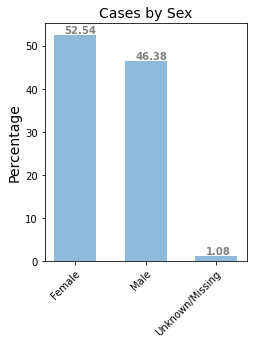

In [1430]:
bar_plot(case_count_sex, case_count_sex['percent'])
plt.subplots_adjust(left=0.2, right=0.9, top=0.9, bottom=0.35);
plt.savefig('../image/demogr_gender.png');


The plot above indicates that there are almost similar percentage of males (52.5%) and females (46.4%) in the reported cases.

In [1431]:
case_count_race=case_count('race')
case_count_race.to_csv('../streamlit/pages/plotting/case_count_race.csv', index=False)
case_count_race

,race,count,percent
0,White,258077,62.498063
1,Unknown/Missing,94896,22.980801
2,Black,45213,10.949154
3,Asian,6808,1.648682
4,Multiple/Other,4555,1.103077
5,American Indian/Alaska Native,3256,0.788500
6,Native Hawaiian/Other Pacific Islander,131,0.031724
Total,Total,412936,100.000000


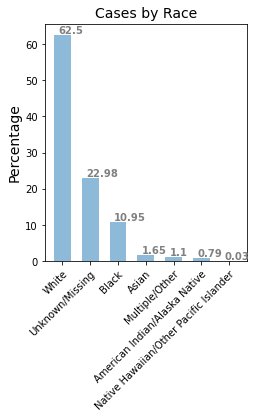

In [1432]:
bar_plot(case_count_race, case_count_race['percent'])
plt.subplots_adjust(left=0.2, right=0.9, top=0.9, bottom=0.35);
plt.savefig('../image/demogr_race.png');


The plot above gives the percentage of different race categories among the reported cases in this dataset.  
White race account for 62% of cases followed by Black. The white race is the majority of population so this is not surprising.   
This data is not normalized with population percentage of different race categories so we cannot necessarily infer that there are more chance of white person being sick.

Normalizing the data with the US population percentage of race below.
(data source: https://usafacts.org/data/topics/people-society/population-and-demographics/our-changing-population)


In [1433]:
#Adding US Population percentatge column for differnet races
case_count_race['pop_pct']=[59.3,0,12.6,5.9,2.3,0.7,0.2,0]

#Normalizing data
case_count_race['norm_pct']=(case_count_race['percent'])/case_count_race['pop_pct']

# Dropping unknown/Missing and Total from the dataframe - creating a new df to create barplot
case_count_race2=case_count_race[(case_count_race['race']!='Unknown/Missing') & (case_count_race['race']!='Total')].copy()
case_count_race2.to_csv('../streamlit/pages/plotting/case_count_race_norm.csv', index=False)
case_count_race2

,race,count,percent,pop_pct,norm_pct
0,White,258077,62.498063,59.3,1.053930
2,Black,45213,10.949154,12.6,0.868981
3,Asian,6808,1.648682,5.9,0.279438
4,Multiple/Other,4555,1.103077,2.3,0.479598
5,American Indian/Alaska Native,3256,0.788500,0.7,1.126428
6,Native Hawaiian/Other Pacific Islander,131,0.031724,0.2,0.158620


In [1434]:
def bar_plot_norm(df,col):
    figure, ax=plt.subplots(figsize=(4,6))
    ax.bar( x=df.iloc[:,0], height=col, width=0.6, alpha=0.5)

    ax.set_title(f'Cases by {df.columns[0].title()}\n Normalized', size=14)
    ax.set_ylabel('Normalized Percentage', size=14)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(df.iloc[:,0], rotation=45, ha='right', rotation_mode='anchor')

    for i in ax.patches:
        if i.get_height() >0:
            plt.text(i.get_x()+0.1, i.get_height()+0.02,
                    str(round((i.get_height()), 2)),
                    fontsize = 10, fontweight ='bold',
                    color ='grey');
        else:
            pass

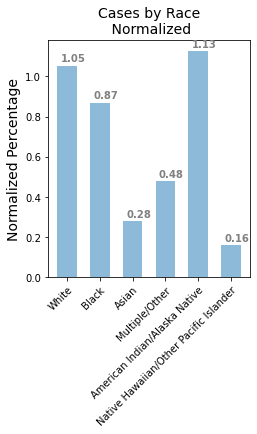

In [1435]:
bar_plot_norm(case_count_race2,case_count_race2['norm_pct'])
plt.subplots_adjust(left=0.2, right=0.9, top=0.9, bottom=0.35);
plt.savefig('../image/demogr_race_norm.png');


The plot above shows normalized percentage of cases by race (normalized with respective population percentages).  
This gives an insight on which race is getting more sick. From our analysis, white and american indian/alaskan native are high risk categories followed by black.

In [1436]:
case_count_ethnicity=case_count('ethnicity')
case_count_ethnicity.to_csv('../streamlit/pages/plotting/case_count_ethnicity.csv', index=False)
case_count_ethnicity

,ethnicity,count,percent
0,Non-Hispanic/Latino,262518,63.573532
1,Unknown/Missing,117968,28.568107
2,Hispanic/Latino,32450,7.858361
Total,Total,412936,100.000000


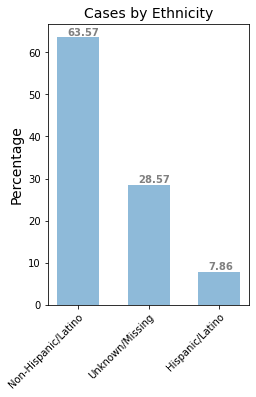

In [1437]:
bar_plot(case_count_ethnicity, case_count_ethnicity['percent'])
plt.subplots_adjust(left=0.2, right=0.9, top=0.9, bottom=0.25);
plt.savefig('../image/demogr_ethnicity.png');

The plot above shows the hospitalization rate by ethnicity.   
Normalizing the data with US population percentage below.

In [1438]:
#Adding US Population percentatge column for differnet ethnicities
case_count_ethnicity['pop_pct']=[81.1,0,18.9,0]

#Normalizing data
case_count_ethnicity['norm_pct']=(case_count_ethnicity['percent'])/case_count_ethnicity['pop_pct']

# Dropping unknown/Missing and Total from the dataframe to create barplot
case_count_ethnicity2=case_count_ethnicity[(case_count_ethnicity['ethnicity']!='Unknown/Missing') & (case_count_ethnicity['ethnicity']!='Total')].copy()
case_count_ethnicity2.to_csv('../streamlit/pages/plotting/case_count_ethnicity_norm.csv', index=False)
case_count_ethnicity2

,ethnicity,count,percent,pop_pct,norm_pct
0,Non-Hispanic/Latino,262518,63.573532,81.1,0.783891
2,Hispanic/Latino,32450,7.858361,18.9,0.415786


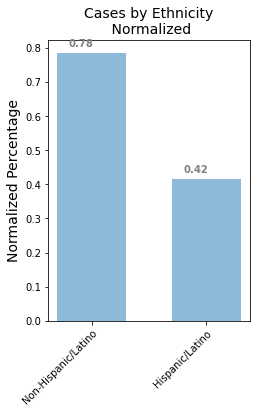

In [1439]:
bar_plot_norm(case_count_ethnicity2,case_count_ethnicity2['norm_pct'])
plt.subplots_adjust(left=0.2, right=0.9, top=0.9, bottom=0.25);
plt.savefig('../image/demogr_ethnicity_norm.png');

The plot above shows normalized percentage of cases by ethnicity (normalized with respective population percentages).  
This gives an insight on which ethnic group is getting more sick. From our analysis, Non-hispanic/Latino ethnic group has relatively higher cases than hispanic/latino group when normalized with respective population percentages.

In [1440]:
case_count_age=case_count('age_group')
case_count_age.to_csv('../streamlit/pages/plotting/case_count_age.csv', index=False)
case_count_age

,age_group,count,percent
0,18 to 49 years,226532,54.858864
1,50 to 64 years,72701,17.605876
2,0 - 17 years,60208,14.580468
3,65+ years,48668,11.785846
4,Missing,4827,1.168946
Total,Total,412936,100.000000


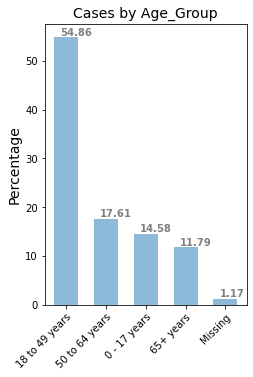

In [1441]:
bar_plot(case_count_age, case_count_age['percent'])
plt.subplots_adjust(left=0.2, right=0.9, top=0.9, bottom=0.25);
plt.savefig('../image/demogr_age.png');

The plot above shows percentage of cases by age group.
Normalizing data with approximate age-group population percentage below.

In [1442]:
#Adding US Population percentatge column for differnet ethnicities
case_count_age['pop_pct']=[39.2,19.2,24.8,16.8,0,0]

#Normalizing data
case_count_age['norm_pct']=(case_count_age['percent'])/case_count_age['pop_pct']

# Dropping unknown/Missing and Total from the dataframe to create barplot
case_count_age2=case_count_age[(case_count_age['age_group']!='Unknown/Missing') & (case_count_age['age_group']!='Total') & (case_count_age['age_group']!='Missing')].copy()
case_count_age2.to_csv('../streamlit/pages/plotting/case_count_age_norm.csv', index=False)
case_count_age2

,age_group,count,percent,pop_pct,norm_pct
0,18 to 49 years,226532,54.858864,39.2,1.399461
1,50 to 64 years,72701,17.605876,19.2,0.916973
2,0 - 17 years,60208,14.580468,24.8,0.587922
3,65+ years,48668,11.785846,16.8,0.701538


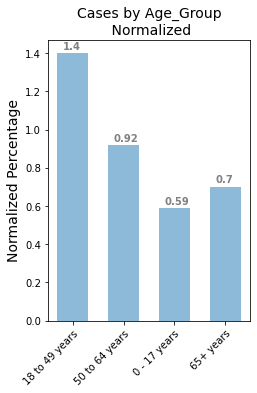

In [1443]:
bar_plot_norm(case_count_age2,case_count_age2['norm_pct'])
plt.subplots_adjust(left=0.2, right=0.9, top=0.9, bottom=0.25);
plt.savefig('../image/demogr_age_norm.png');

The plot above shows normalized percentage of cases by age group (normalized with respective population percentages).  
This gives an insight on which age group is getting mroe sick. From our analysis, 18-49 years age group has more no of cases relative to their population percentages. 

In [1444]:
df_surv['hosp_yn'].value_counts()

Missing    186852
No         133293
Unknown     82062
Yes         10729
Name: hosp_yn, dtype: int64

In [1458]:
case_count_state=case_count('res_state')
case_count_state

,res_state,count,percent
0,TX,26791,6.487930
1,NC,22201,5.376378
2,PA,22135,5.360395
3,CA,21691,5.252872
4,FL,20441,4.950162
5,OH,20427,4.946771
6,NY,18046,4.370169
7,IL,16886,4.089254
8,GA,15496,3.752640
9,NJ,14973,3.625986


**Creating a dataframe with state full name and abbreviations**

In [1446]:
#Creating a Dataframe with all the state names and abbreviations
df_states=pd.read_csv('../data/US_state_two_letter_abbreviations.csv')

In [1447]:
df_states.head()

,State,State_ID
0,Alabama,AL
1,Alaska,AK
2,Arizona,AZ
3,Arkansas,AR
4,California,CA


In [1448]:
#Renaming state ID column and creating a right hande side column for full state name, dropping the first column

df_states.rename(columns={'State_ID': 'res_state'}, inplace=True)
df_states['res_state_name']=df_states['State']
df_states.drop(columns='State', inplace=True)

In [1449]:
#Adding DC as a state
df_states=pd.concat([df_states, pd.DataFrame({'res_state': ['DC'], 'res_state_name':['Washington DC']})])

In [1450]:
df_states.reset_index(inplace=True)
df_states.drop(columns=['index'], inplace=True)

In [1451]:
df_states.head()

,res_state,res_state_name
0,AL,Alabama
1,AK,Alaska
2,AZ,Arizona
3,AR,Arkansas
4,CA,California


**Case Percentage by State**

In [1459]:
#Adding a column for full state name 
case_count_state=pd.merge(case_count_state, df_states, on='res_state', how='outer')

In [1460]:
case_count_state.sort_values(by='percent', ascending=False,inplace=True)

In [1462]:
case_count_state.dropna(inplace=True)
case_count_state

,res_state,count,percent,res_state_name
0,TX,26791.0,6.487930,Texas
1,NC,22201.0,5.376378,North Carolina
2,PA,22135.0,5.360395,Pennsylvania
3,CA,21691.0,5.252872,California
4,FL,20441.0,4.950162,Florida
5,OH,20427.0,4.946771,Ohio
6,NY,18046.0,4.370169,New York
7,IL,16886.0,4.089254,Illinois
8,GA,15496.0,3.752640,Georgia
9,NJ,14973.0,3.625986,New Jersey


In [1561]:
def barh_plot_pct(y, width, title, xlabel, ylabel):
    figure, ax=plt.subplots(figsize=(20,15))
    ax.barh(y, width)
    ax.set_title(title, size=14)
    ax.set_xlabel(xlabel,size=14)
    ax.set_ylabel(ylabel,size=14);
    for i in ax.patches:
        if i.get_width() >0:
            plt.text(i.get_width()+0.15, i.get_y()+0.4,
                     str(round((i.get_width()), 2)),
                     fontsize = 10, fontweight ='bold',
                     color ='grey');
        else:
            pass
    plt.show()

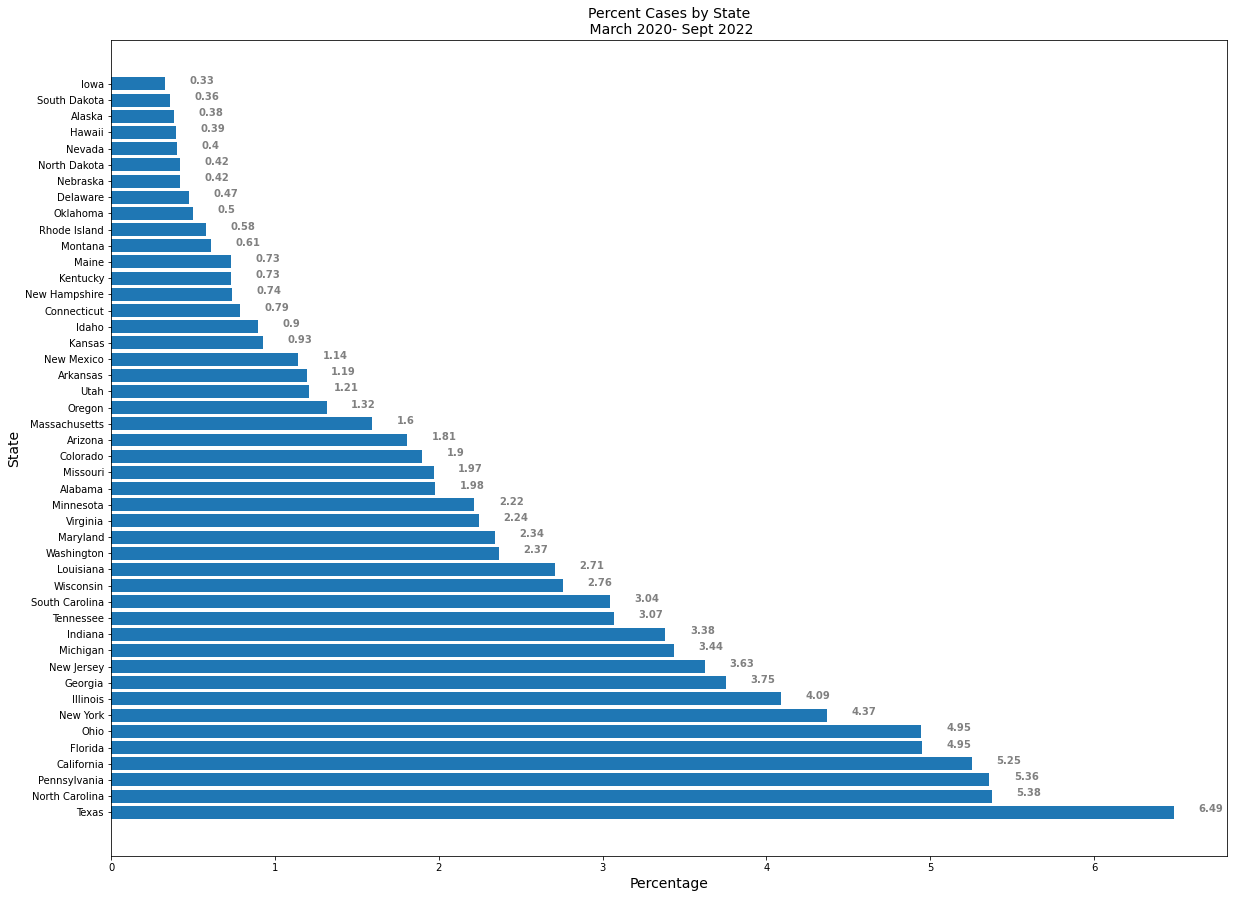

<Figure size 432x288 with 0 Axes>

In [1570]:
barh_plot_pct(case_count_state.iloc[:-3,3], case_count_state.iloc[:-3,2],'Percent Cases by State\n March 2020- Sept 2022', 'Percentage','State')
plt.subplots_adjust(left=0.2, right=0.9, top=0.9, bottom=0.25);
# plt.savefig('../image/cases_pct_state.png');


The plot above shows case percentage by state for the period of March 2020 to September 2022.  
Some of the states with highest share of COVID cases are: Texas, North Carolina, Pennsylvania, California, Florida, Ohio, New York etc.


**Looking at Hospitalization, icu and death data**

In [1465]:
df_surv.head()

,res_state,age_group,sex,race,ethnicity,symptom_status,hosp_yn,icu_yn,death_yn
case_month,,,,,,,,,
2020-03-01,PA,18 to 49 years,Female,White,Non-Hispanic/Latino,Symptomatic,Unknown,Unknown,Unknown
2020-03-01,LA,65+ years,Male,Black,Non-Hispanic/Latino,Unknown,Unknown,Unknown,Missing
2020-03-01,NJ,18 to 49 years,Female,Black,Non-Hispanic/Latino,Symptomatic,Missing,Missing,No
2020-03-01,PA,18 to 49 years,Female,White,Non-Hispanic/Latino,Symptomatic,No,No,No
2020-03-01,MI,18 to 49 years,Female,White,Non-Hispanic/Latino,Symptomatic,No,Missing,No


In [1466]:
case_count_hosp=case_count('hosp_yn')
case_count_hosp

,hosp_yn,count,percent
0,No,133293,32.279336
1,Unknown/Missing,268914,65.122440
2,Yes,10729,2.598223
Total,Total,412936,100.000000


In [1467]:
case_count_icu=case_count('icu_yn')
case_count_icu

,icu_yn,count,percent
0,Unknown/Missing,402681,97.516564
1,No,9774,2.366953
2,Yes,481,0.116483
Total,Total,412936,100.000000


In [1468]:
case_count_death=case_count('death_yn')
case_count_death

,death_yn,count,percent
0,No,151470,36.681229
1,Unknown/Missing,259797,62.914592
2,Yes,1669,0.404179
Total,Total,412936,100.000000


In [1469]:
case_count_symptom=case_count('symptom_status')
case_count_symptom

,symptom_status,count,percent
0,Symptomatic,160046,38.758064
1,Unknown/Missing,248748,60.238875
2,Asymptomatic,4142,1.003061
Total,Total,412936,100.000000


There are large no. of missing/unknown entries for icu data.  
Decising to drop the icu column.

In [1470]:
#Deciding to drop the 'icu_yn' column because of large no of missing values
df_surv.drop(columns=['icu_yn'],inplace=True)

In [1471]:
df_surv.shape

(412936, 8)

### Hospitalization EDA

Creating two datasts  
1. Dropping the missing and unknown for hosp_yn  
2. Imputing the missing and unknown for hosp_yn with 'NO'- deciding to use this data set for final analysis

In [1472]:
#Dropping the rows containing missing or unknown values for hospitalization_yn column
df_surv_hosp=df_surv[(df_surv['hosp_yn']=='Yes') | (df_surv['hosp_yn']=='No')].copy()

In [1473]:
df_surv_hosp.shape

(144022, 8)

In [1474]:
#Imputing the missing and unkown values for hospitalization_yn column with 'No'
df_surv_hosp_comp=df_surv.copy()
df_surv_hosp_comp['hosp_yn']=df_surv_hosp_comp['hosp_yn'].map(lambda x: 'No' if (x == 'Missing') | (x == 'Unknown') else x)

In [1475]:
#binarizing hosp_yn
df_surv_hosp['hosp_yn']=df_surv_hosp['hosp_yn'].map(lambda x: 1 if x=='Yes' else 0)
df_surv_hosp_comp['hosp_yn']=df_surv_hosp_comp['hosp_yn'].map(lambda x: 1 if x=='Yes' else 0)

In [1477]:
 df_surv_hosp_comp.shape

(412936, 8)

In [1478]:
df_states.head();

In [1479]:
df_surv_states=df_surv_hosp['res_state'].unique()

In [1480]:
df_surv_states

array(['PA', 'MI', 'NJ', 'MO', 'FL', 'LA', 'MA', 'MD', 'CO', 'TX', 'IA',
       'IL', 'WA', 'OH', 'WI', 'MN', 'CT', 'SC', 'NY', 'VA', 'AL', 'NC',
       'NM', 'NV', 'CA', 'OK', 'AZ', 'NH', 'OR', 'TN', 'AR', 'KY', 'IN',
       'GA', 'ID', 'KS', 'UT', 'ND', 'MT', 'WY', 'ME', 'DC', 'VT', 'AK',
       'NE', 'HI'], dtype=object)

In [1481]:
len(df_surv_states)

46

**Looking at hospitalization rates for each state**  
We will look at the no. of hospitalization relative to total number of cases for each state to understand which states are at highest risk.

In [1482]:
def state_hosp(df, states):
    '''This function calculates the hospitalization percentage rate for state per month'''
    i=1
    for state in states:
        df_state=df[df['res_state']==state].copy()
        df_state.reset_index(inplace=True)
        state_hosp=df_state.groupby(by='case_month')['hosp_yn'].aggregate('sum')
        state_total=df_state.groupby(by='case_month')['hosp_yn'].aggregate('count')
        state_percentage=(state_hosp/state_total)*100
        
        if i==1:
            df_state_hosp=pd.DataFrame(state_percentage)
            df_state_hosp_total=pd.DataFrame(state_total)
        else:
            df_state_hosp1=pd.DataFrame(state_percentage)
            df_state_hosp=pd.concat([df_state_hosp, df_state_hosp1], axis=1)
            
            df_state_hosp_total1=pd.DataFrame(state_total)
            df_state_hosp_total=pd.concat([df_state_hosp_total, df_state_hosp_total1], axis=1)
        i+=1
         
        df_state_hosp.rename(columns={df_state_hosp.columns[-1]: state},inplace=True)
        df_state_hosp_total.rename(columns={df_state_hosp_total.columns[-1]: state},inplace=True)
       
    return df_state_hosp, df_state_hosp_total

In [1553]:
def plot_state_hosp(df_state_hosp,states):
    '''This function creates the time plot of cases for state'''
    
    plt.figure(figsize=(8,6))   
    for state in states:
        plt.plot(df_state_hosp[states], label=state)
    plt.title('Time plot of Total No. of Cases by State', size=14)
    plt.ylabel('No. of cases', size=14)
    plt.xlabel('Month', size=14)
    plt.xticks(rotation=90);
    plt.legend();
    return 

In [1484]:
#-----Naming convention----
# df_state_hosp- has the hospitalization percentage - dropped missing and unknown
#df_state_hosp_total- has total number of cases 
# df_state_hosp_comp- has the hospitalization percentage - imputing missing and unknown hospitalization - 0
#df_state_hosp_comp_total- has total number of cases 
# ---------

#Calculating hospitalization rates for all the states- dropped missing/rename
df_state_hosp,df_state_hosp_total=state_hosp(df_surv_hosp,df_surv_states)

#Calculating hospitalization rates for all the states-  including missing/rename as 0
df_state_hosp_comp, df_state_hosp_comp_total=state_hosp(df_surv_hosp_comp,df_surv_states)



In [1485]:
#Dataframe with hospitalization rate (%) for each state
df_state_hosp_comp.head()

,PA,MI,NJ,MO,FL,LA,MA,MD,CO,TX,IA,IL,WA,OH,WI,MN,CT,SC,NY,VA,AL,NC,NM,NV,CA,OK,AZ,NH,OR,TN,AR,KY,IN,GA,ID,KS,UT,ND,MT,WY,ME,DC,VT,AK,NE,HI
case_month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-01,9.401709,1.960784,49.056604,8.333333,10.000000,19.287834,0.000000,20.000000,42.857143,19.047619,0.000000,33.333333,44.736842,16.666667,37.500000,54.545455,40.909091,5.263158,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-01,7.547170,NaN,47.629310,NaN,NaN,2.721088,11.764706,NaN,27.272727,NaN,NaN,50.467290,0.000000,NaN,30.882353,2.857143,NaN,NaN,13.588850,7.920792,7.575758,0.000000,34.375000,29.411765,28.571429,3.448276,27.272727,2.941176,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
2020-05-01,8.074534,7.317073,14.285714,NaN,3.846154,7.142857,0.000000,0.884956,NaN,8.695652,4.504505,NaN,3.030303,15.789474,NaN,NaN,NaN,29.629630,5.434783,0.000000,NaN,2.173913,19.786096,NaN,NaN,NaN,1.818182,5.555556,2.941176,0.000000,7.547170,2.564103,4.545455,2.631579,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-01,1.315789,0.000000,15.646259,0.000000,2.678571,2.114804,NaN,0.000000,NaN,8.173562,NaN,NaN,3.846154,16.666667,0.000000,3.636364,0.000000,4.848485,1.785714,0.000000,0.000000,7.920792,2.197802,NaN,4.918033,0.000000,12.149533,NaN,8.333333,14.285714,10.404624,NaN,2.439024,0.000000,2.469136,0.0,0.0,3.125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-01,NaN,2.531646,4.347826,4.838710,9.298532,1.851852,1.694915,1.530612,NaN,6.909789,NaN,NaN,4.081633,4.210526,14.678899,2.139037,NaN,6.598985,8.979592,2.941176,0.000000,3.587444,1.123596,11.538462,2.994012,1.562500,33.333333,NaN,3.157895,5.851064,NaN,NaN,0.571429,0.000000,2.173913,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1486]:
#Dataframe with total no. of cases for each state
df_state_hosp_comp_total.head()

,PA,MI,NJ,MO,FL,LA,MA,MD,CO,TX,IA,IL,WA,OH,WI,MN,CT,SC,NY,VA,AL,NC,NM,NV,CA,OK,AZ,NH,OR,TN,AR,KY,IN,GA,ID,KS,UT,ND,MT,WY,ME,DC,VT,AK,NE,HI
case_month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-01,117.0,51.0,212.0,12.0,20.0,337.0,14.0,10.0,14.0,42.0,56.0,18.0,38.0,12.0,16.0,11.0,22.0,19.0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-01,265.0,NaN,464.0,NaN,NaN,147.0,68.0,NaN,22.0,NaN,NaN,107.0,12.0,NaN,68.0,35.0,NaN,NaN,287,101.0,66.0,14.0,64.0,17.0,21.0,29.0,11.0,34.0,NaN,NaN,NaN,NaN,NaN,45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0,NaN
2020-05-01,161.0,41.0,63.0,NaN,26.0,14.0,34.0,113.0,NaN,46.0,111.0,NaN,33.0,38.0,NaN,NaN,NaN,27.0,276,14.0,NaN,46.0,374.0,NaN,NaN,NaN,55.0,18.0,34.0,12.0,106.0,39.0,22.0,76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-01,76.0,45.0,147.0,36.0,224.0,331.0,NaN,17.0,NaN,991.0,NaN,NaN,78.0,192.0,12.0,55.0,54.0,165.0,224,37.0,24.0,202.0,182.0,NaN,244.0,17.0,214.0,NaN,24.0,14.0,173.0,NaN,41.0,519,162.0,15.0,21.0,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-01,NaN,158.0,23.0,62.0,613.0,540.0,118.0,392.0,NaN,521.0,NaN,NaN,98.0,285.0,109.0,187.0,NaN,394.0,245,102.0,269.0,446.0,89.0,26.0,167.0,64.0,27.0,NaN,95.0,188.0,NaN,NaN,175.0,618,230.0,77.0,NaN,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


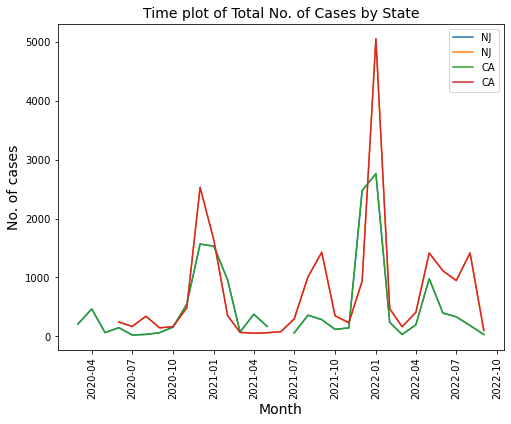

In [1554]:
plot_state_hosp(df_state_hosp_comp_total,['NJ','CA'])


The plot above shows time plot of cases for the period of March-2020 to September 2022 for New Jersey and California. Some interesting peaks are seen during October-January 2020, 2022 as expected and some small peaks during fall 2021 and spring-fall 2022. 

**Resampling data quarterly for some coarse EDA**

In [1490]:
#resampling quarterly- hospitalization percentage
state_hosp_quaterly=df_state_hosp_comp.resample('Q').mean()

In [1491]:
state_hosp_quaterly.tail()

,PA,MI,NJ,MO,FL,LA,MA,MD,CO,TX,IA,IL,WA,OH,WI,MN,CT,SC,NY,VA,AL,NC,NM,NV,CA,OK,AZ,NH,OR,TN,AR,KY,IN,GA,ID,KS,UT,ND,MT,WY,ME,DC,VT,AK,NE,HI
case_month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-09-30,0.284238,2.112852,8.432170,0.827959,5.510734,0.058275,3.488372,2.812078,3.796791,6.307353,0.0,10.456452,2.690775,3.998614,7.781444,10.060374,0.00000,3.650716,1.147919,0.418520,1.034100,1.571350,8.048810,4.779412,4.255052,3.847390,5.382471,0.000000,3.455523,4.302579,5.759357,0.831500,0.564937,0.079793,5.731287,4.000000,0.19084,NaN,9.663582,5.333333,1.666667,NaN,NaN,1.778416,0.0,0.0
2021-12-31,0.994700,1.137566,8.638049,0.136054,1.140103,0.904977,0.000000,5.249236,7.224025,2.080205,0.0,2.351688,5.821887,4.662423,3.598230,4.025081,0.00000,1.264977,0.454535,0.964179,0.595238,1.756467,0.692284,10.245902,1.154336,0.534759,5.513531,0.000000,1.234568,2.140272,3.178324,10.125353,2.816699,0.044623,2.802216,16.408451,0.00000,0.426309,3.288205,2.103250,2.262092,19.54023,0.0,0.387597,0.0,0.0
2022-03-31,3.274300,0.471959,4.130462,4.225235,1.138306,0.011100,0.000000,4.657127,4.820347,0.437228,NaN,4.406381,4.351324,8.290374,5.066365,3.691689,0.00000,1.336182,0.504199,0.561734,0.340479,0.994442,4.432698,0.000000,0.850755,NaN,3.812293,0.247158,0.624370,0.553122,1.636198,2.647059,0.167657,0.041946,1.451613,3.842382,0.02451,3.317772,3.571429,0.000000,0.741882,NaN,0.0,1.234568,0.0,0.0
2022-06-30,4.195247,0.481289,4.555235,0.273224,1.245404,0.000000,0.168350,1.383122,1.987464,1.056710,NaN,1.015707,3.506936,2.116992,1.610986,3.136316,0.00000,0.000000,0.000000,0.089606,0.000000,0.160376,7.150673,9.821429,1.471325,NaN,3.500961,0.000000,0.696677,1.225115,8.333333,32.954545,0.000000,0.099354,1.470588,1.422764,0.00000,3.571429,0.000000,0.000000,0.358423,NaN,0.0,NaN,NaN,0.0
2022-09-30,1.125831,0.797599,6.708782,0.000000,0.564027,0.000000,2.525253,0.495908,4.049346,0.125692,NaN,0.982841,14.652031,1.518330,0.909841,5.256464,0.78125,0.435730,0.000000,0.672629,0.000000,1.749199,0.000000,0.000000,1.868598,NaN,5.347900,0.000000,2.222222,0.827755,4.819820,0.000000,0.246914,0.000000,1.307190,4.166667,0.00000,NaN,0.000000,NaN,7.638889,NaN,NaN,1.000000,0.0,0.0


In [1492]:
#resampling quarterly- total number of cases
state_hosp_quaterly_total=df_state_hosp_comp_total.resample('Q').mean()

In [1493]:
state_hosp_quaterly_total.index

DatetimeIndex(['2020-03-31', '2020-06-30', '2020-09-30', '2020-12-31',
               '2021-03-31', '2021-06-30', '2021-09-30', '2021-12-31',
               '2022-03-31', '2022-06-30', '2022-09-30'],
              dtype='datetime64[ns]', name='case_month', freq='Q-DEC')

In [1555]:
#Help from https://www.geeksforgeeks.org/matplotlib-axis-axis-set_tick_params-in-python/

def hosp_time_plot(df_state_hosp, df_surv_states, title, ylabel):
    
    '''This function creates time plot of no. of cases for all the states'''
    figure, ax = plt.subplots(nrows=5,ncols=2, figsize=(16,20))
    figure.tight_layout(h_pad=8, w_pad=6)
    # df_state_hosp=df_state_hosp.reset_index()
    k=1
    for i in range (5):
        for j in range(2):
            ax[i][j].plot(df_state_hosp[df_surv_states[(k-1)*5:(k-1)*5+5]], label=df_surv_states[(k-1)*5:(k-1)*5+5])
            k+=1
            ax[i][j].set_ylabel(ylabel, size=12)
            ax[i][j].xaxis.set_tick_params(rotation=90)
            ax[i][j].legend()
           
        plt.suptitle(title, size=14)
        plt.subplots_adjust(left=0.2, right=0.9, top=0.9, bottom=0.1);
     
    return
    


In [1495]:
# hosp_time_plot(state_hosp_quaterly, df_surv_states, 'Hospitalization Rates by State\nQuarterly', 'Hospitalization (%)')

In [1496]:
# hosp_time_plot(df_state_hosp_comp, df_surv_states, 'Hospitalization Rates by State\n Monthly', 'Hospitalization (%)')

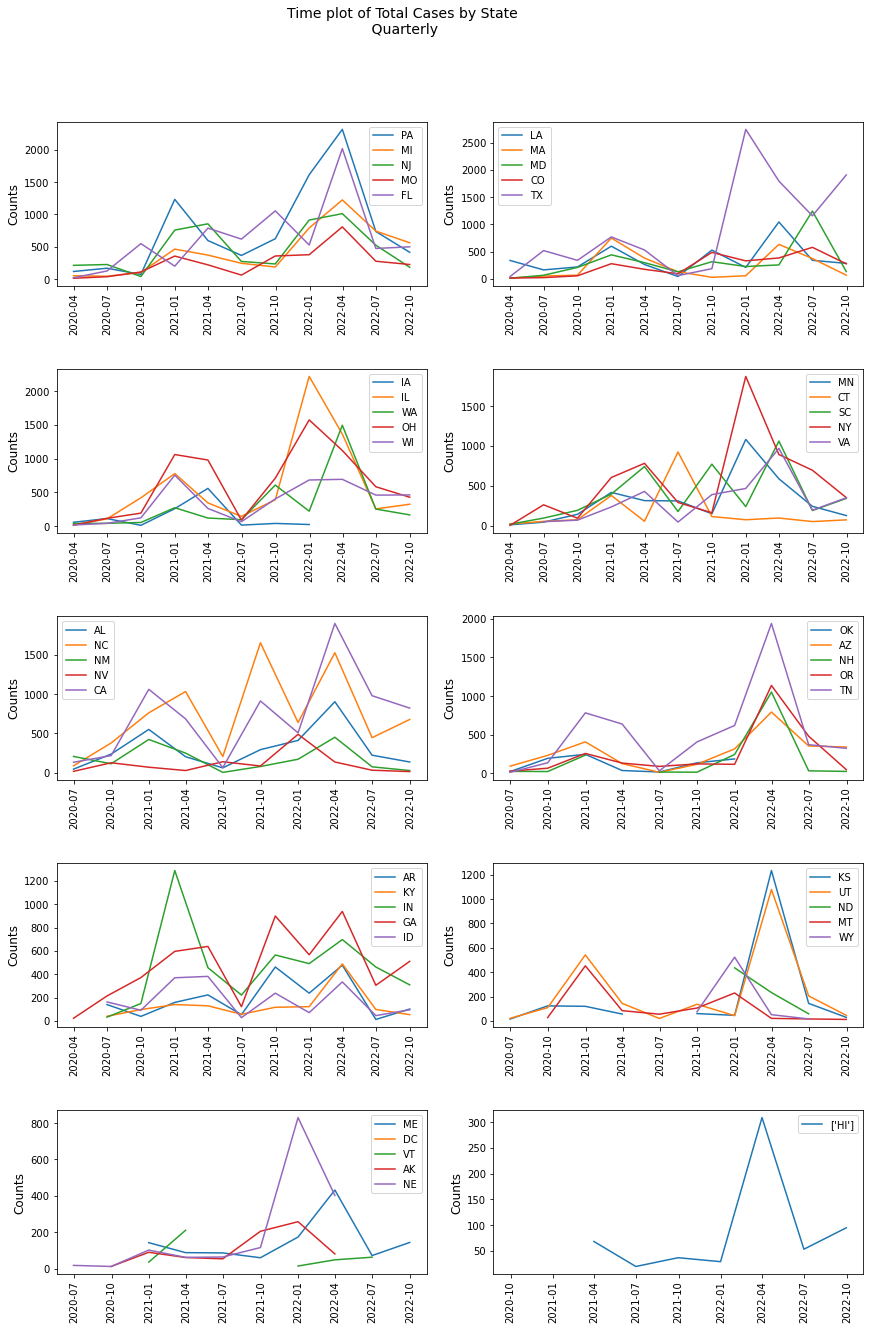

In [1556]:
hosp_time_plot(state_hosp_quaterly_total, df_surv_states, 'Time plot of Total Cases by State\n Quarterly', 'Counts')

The figure above shows evolution of COVID case counts over time for all the states. It is interesting to note similar peaks for all the states especially during winter 2020 and 2021 but also high peak around April 2022.

In [1499]:
df_state_hosp_comp_total.to_csv('../streamlit/pages/plotting/time_state_hospt_total.csv')

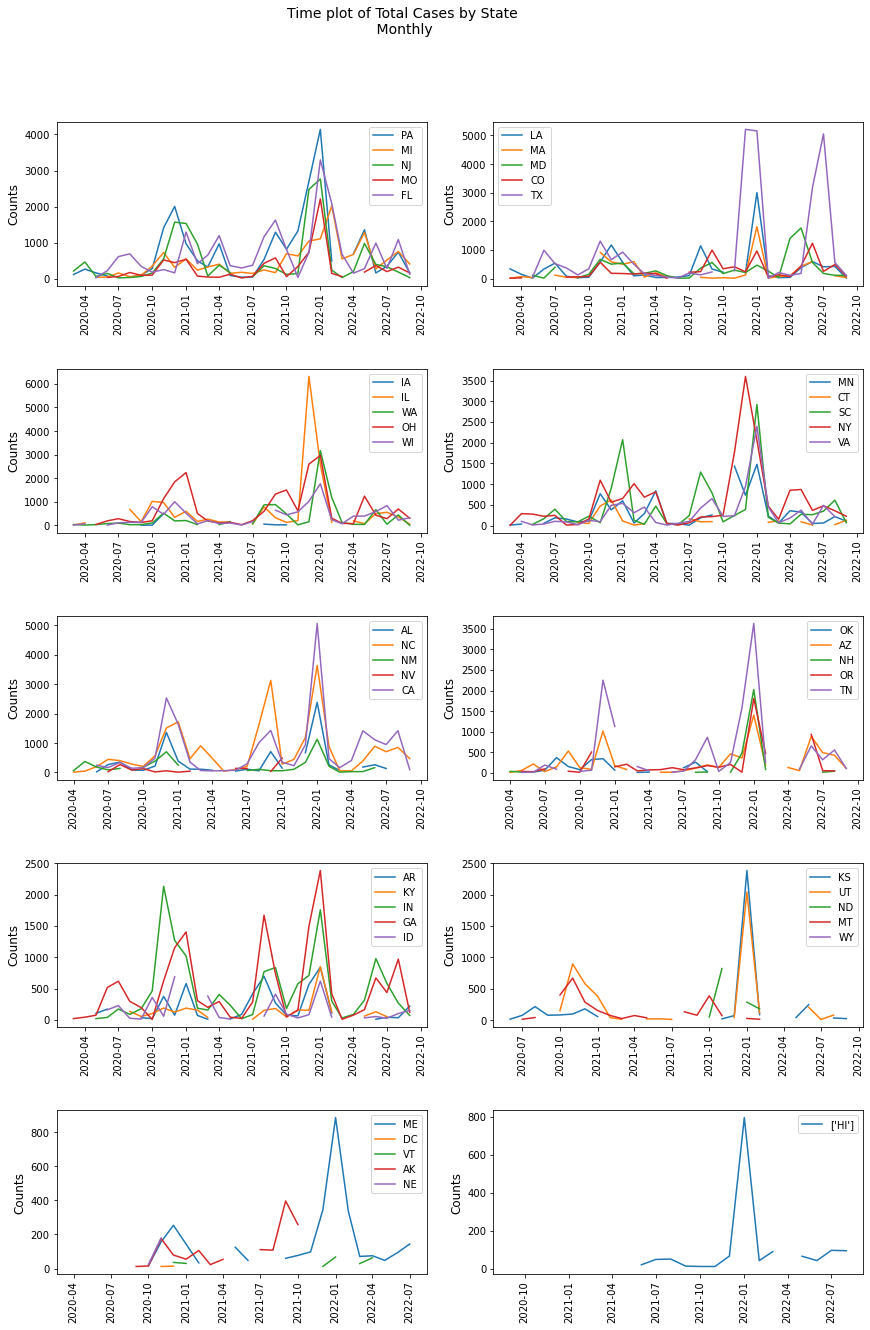

In [1571]:
hosp_time_plot(df_state_hosp_comp_total, df_surv_states, 'Time plot of Total Cases by State\n Monthly', 'Counts')
plt.savefig('../image/time_cases_state.png');

The figure above shows the time plot of total cases (monthly) for ale the states. This gives a more granular picture of evolution of number of cases. Similar to the quarterly results, there are strong peaks during the winter of 2020, fall of 2021 and much stronger peak around winter 2022. Some of the states like Texas, California, North Carolina, Georgia, Indiana, Arizona, Tennesse show considerable increase in cases during summer of 2022.  
Some of the states are missing a lot of data- it could be the data collection issue.

**Recent hospitalization rates (percentage) by state:- September 2022**

In [1502]:
#Getting hosp rates for Sept 2022
df_state_hosp_recent=pd.DataFrame(df_state_hosp_comp.loc['2022-09':'2022-09'].mean().sort_values(ascending=False))

In [1503]:
df_state_hosp_recent.head(5)

,0
WA,33.333333
AR,9.459459
NJ,9.375000
KS,8.333333
AZ,7.407407


In [1504]:
recent=df_state_hosp_recent.reset_index()
recent.head()
recent.rename(columns={'index': 'State', 0:'Hospitalization Rate'}, inplace=True)


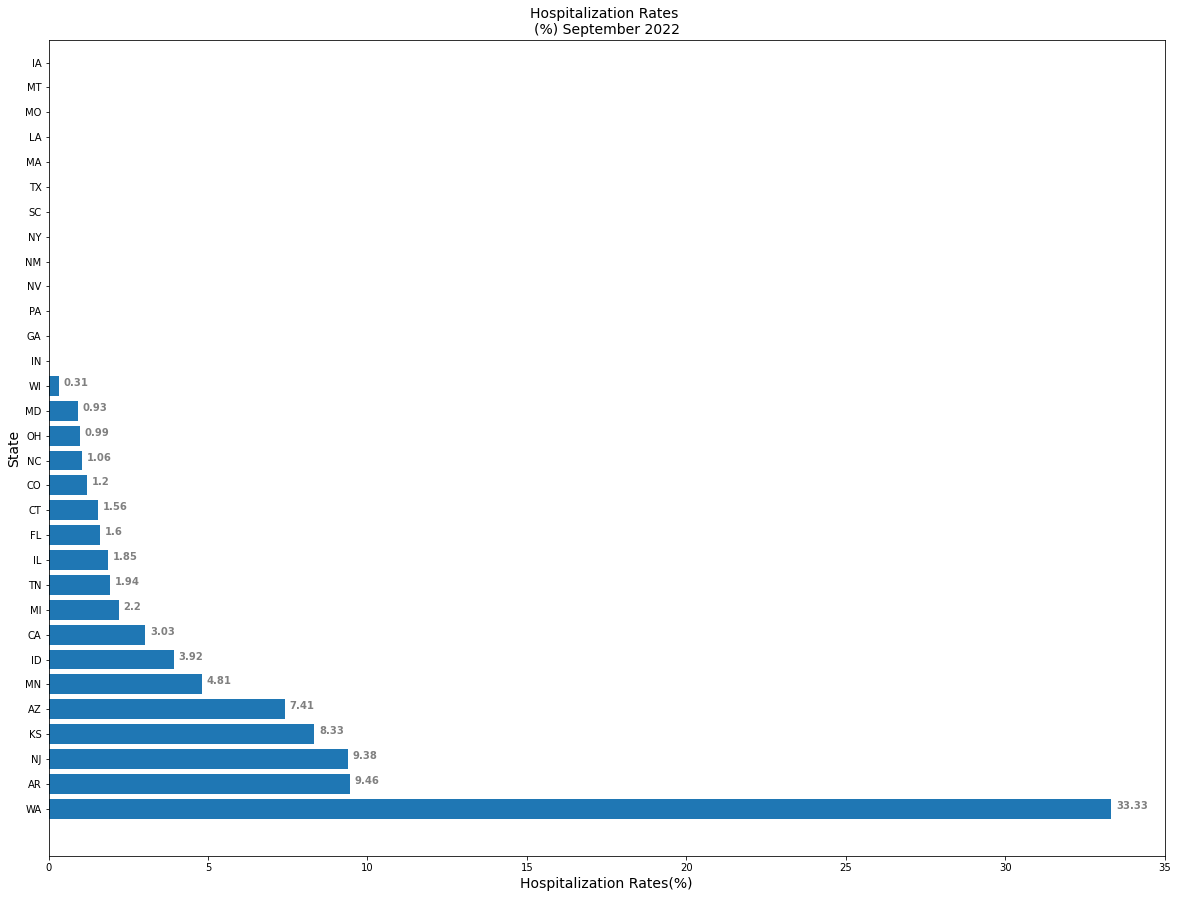

In [1565]:
barh_plot_pct(recent['State'], recent['Hospitalization Rate'],'Hospitalization Rates \n(%) September 2022','Hospitalization Rates(%)','State')

The plot above shows the hospitalization rates by state for the month of September.  
Some of the states with highest hospitalization rates for the month of September are Washington, Askansas, New Jersey etc.

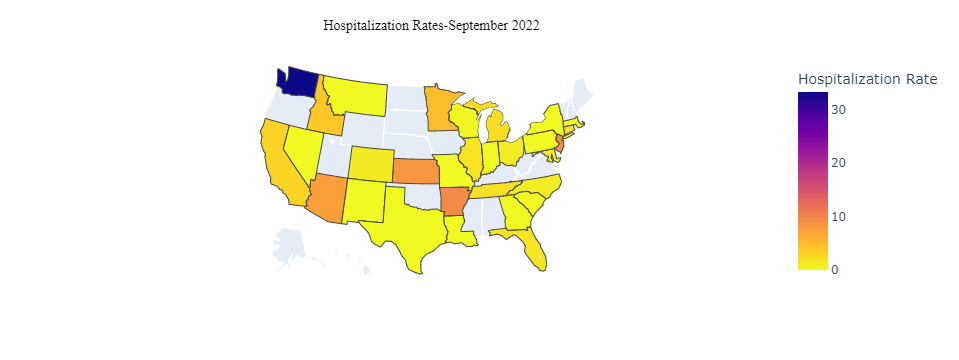

In [1600]:
#Hospitalization rate visualization on country map
# Code adapted from :
#https://towardsdatascience.com/simplest-way-of-creating-a-choropleth-map-by-u-s-states-in-python-f359ada7735e

import plotly.express as px
fig = px.choropleth(recent,
                    locations=recent['State'], 
                    locationmode="USA-states", 
                    scope="usa",
                    color=recent['Hospitalization Rate'],
                    color_continuous_scale="Plasma_r", 
                    # labels={'act_participation_rate': 'ACT Participation Rate'}
                    )
fig.update_layout(
      title_text = 'Hospitalization Rates-September 2022',
      title_font_family="Times New Roman",
      title_font_size = 14,
      title_font_color="black", 
      title_x=0.45, 
         )
fig.show()
# fig.write_image('../image/hosp_rate_statemap_09_2022.jpg')

**Recent No. of Cases:- September**

In [1507]:
#Getting no. of cases for Sept 2022
df_state_hosp_recent_total=pd.DataFrame(df_state_hosp_comp_total.loc['2022-09':'2022-09'].mean().sort_values(ascending=False))

In [1508]:
df_state_hosp_recent_total.head(5)

,0
NC,471.0
MI,409.0
WI,321.0
OH,303.0
NY,225.0


In [1595]:
recent_total=df_state_hosp_recent_total.reset_index()
recent_total.rename(columns={'index': 'State', 0:'No. of Cases (Mean)'}, inplace=True)
recent_total.to_csv('../streamlit/pages/plotting/recent_total.csv', index=False)
recent_total.sort_values(by='No. of Cases (Mean)', ascending=False).head()

,State,No. of Cases (Mean)
0,NC,471.0
1,MI,409.0
2,WI,321.0
3,OH,303.0
4,NY,225.0


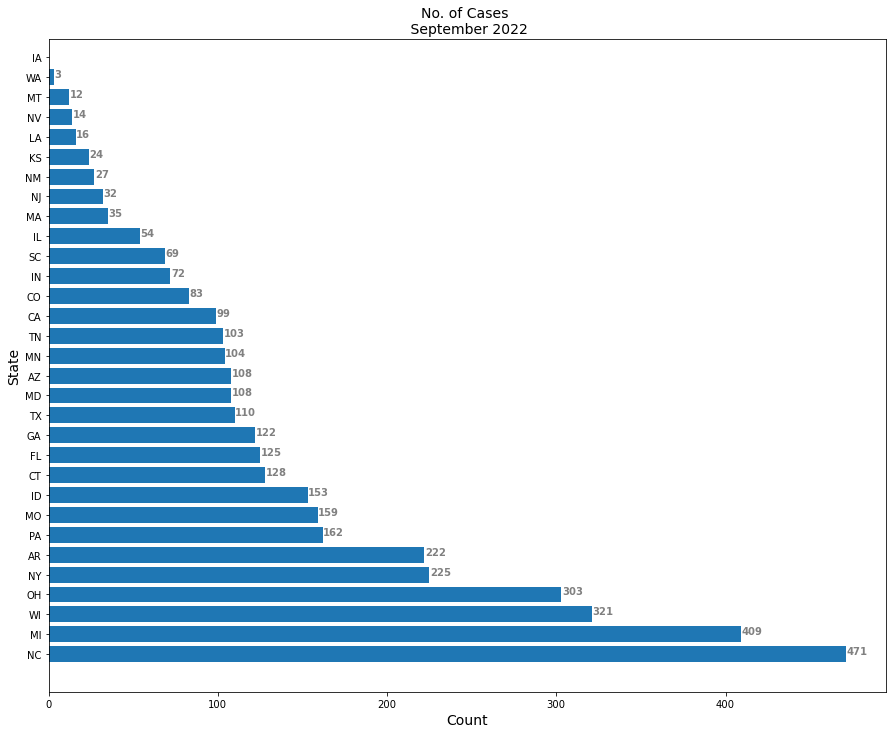

In [1575]:
figure, ax=plt.subplots(figsize=(15,12))
ax.barh(recent_total['State'], recent_total['No. of Cases (Mean)'])
ax.set_title('No. of Cases \n September 2022', size=14)
ax.set_xlabel('Count', size=14)
ax.set_ylabel('State', size=14);
for i in ax.patches:
    if i.get_width() >0:
        plt.text(i.get_width()+0.3, i.get_y()+0.4,
                 str(round((i.get_width()), 2).astype(int)),
                 fontsize = 10, fontweight ='bold',
                 color ='grey');
    else:
        pass
plt.savefig('../image/recent_cases_state.png');

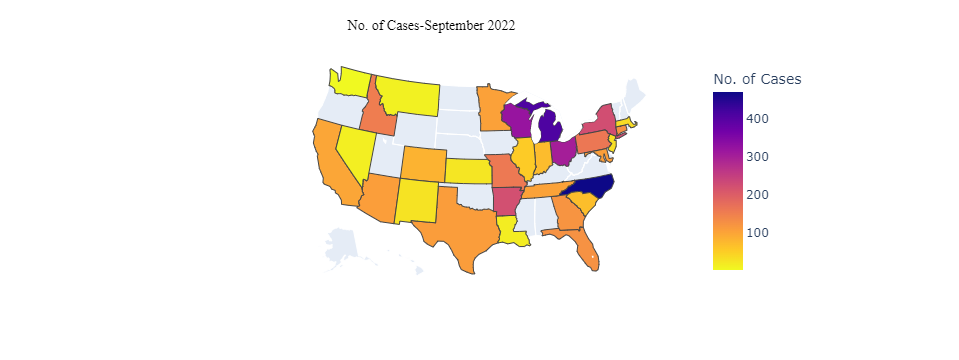

In [1599]:
#No. of cases visualization on country map
# Code adapted from :
#https://towardsdatascience.com/simplest-way-of-creating-a-choropleth-map-by-u-s-states-in-python-f359ada7735e

import plotly.express as px
fig = px.choropleth(recent_total,
                    locations=recent_total['State'], 
                    locationmode="USA-states", 
                    scope="usa",
                    color=recent_total['No. of Cases (Mean)'],
                    color_continuous_scale="Plasma_r", 
                    labels={'No. of Cases (Mean)': 'No. of Cases'}
                    )
fig.update_layout(title_text = 'No. of Cases-September 2022',
                  title_font_family="Times New Roman",
                  title_font_size = 14,
                  title_font_color="black", 
                  title_x=0.45, 
                  coloraxis_colorbar_x=0.78
      )

fig.show()
# fig.write_image('../images/cases_state_map_Sept2022.jpg')

### Data pre-processing for demographic- hospitalization predicitve model
**Cleaning the data of the missing and unknown values for modeling:**

Two types of dataframes were used for modeling.
First started with data where if hosp was missing or unknown, the rows were dropped.  
Later after some thought second dataframe was created, where the missing and unknown values for hosp were replaced with 'no' and one more column-symptom_status was included.

In [1516]:
#Defining function to clean the columns of missing and unknown values
def clean_missing_unknown(df, clean_col_list):
    for col in clean_col_list:
        #Dropping the rows containing missing or unknown values for col
        df=df[(df[col]!='Missing') & (df[col]!='Unknown')].copy()
    return df


In [1517]:
#columns of interest to be cleaned for modeling
clean_col_list=['sex','race','ethnicity','age_group']

**Cleaning hospitalization data with 'missing' and 'unknown' values for hosp removed**

In [1518]:
df_surv_hosp_clean=clean_missing_unknown(df_surv_hosp, clean_col_list)

In [1519]:
df_surv_hosp_clean.shape

(114644, 8)

In [1596]:
#checking cleaned data
list_columns= df_surv_hosp_clean.columns

for col in list_columns:
    print('VALUE COUNTS')
    print(f'Column name: {col}')
    print(df_surv_hosp_clean[col].value_counts())
    print('----------------------------------------')
    

VALUE COUNTS
Column name: res_state
NJ    11521
IN     8978
FL     7590
NC     6341
WI     5934
OH     5438
IL     5125
UT     4938
SC     4877
MI     4624
CA     4073
VA     3957
TX     3493
AZ     2952
TN     2910
MD     2490
PA     2478
NY     2442
NM     2244
KS     1974
ME     1964
LA     1936
AR     1887
CO     1879
WA     1666
ID     1536
MT     1496
OR     1371
NV     1106
AL     1044
KY      964
OK      755
MN      541
WY      513
VT      500
MA      494
AK      138
DC      119
CT      100
IA       96
MO       75
GA       71
NH       13
HI        1
Name: res_state, dtype: int64
----------------------------------------
VALUE COUNTS
Column name: age_group
18 to 49 years    58230
50 to 64 years    22479
0 - 17 years      17180
65+ years         16755
Name: age_group, dtype: int64
----------------------------------------
VALUE COUNTS
Column name: sex
Female    59874
Male      54770
Name: sex, dtype: int64
----------------------------------------
VALUE COUNTS
Column name: race
Whit

In [1521]:
df_surv_hosp_clean.head()

,res_state,age_group,sex,race,ethnicity,symptom_status,hosp_yn,death_yn
case_month,,,,,,,,
2020-03-01,PA,18 to 49 years,Female,White,Non-Hispanic/Latino,Symptomatic,0,No
2020-03-01,MI,18 to 49 years,Female,White,Non-Hispanic/Latino,Symptomatic,0,No
2020-03-01,NJ,18 to 49 years,Male,Black,Non-Hispanic/Latino,Symptomatic,1,No
2020-03-01,PA,65+ years,Female,White,Non-Hispanic/Latino,Symptomatic,0,No
2020-03-01,NJ,18 to 49 years,Male,Black,Non-Hispanic/Latino,Symptomatic,1,No


In [1522]:
df_surv_hosp_clean.to_csv('../data/clean_data/covid_surveillance_hospitalization.csv')

**Cleaning hospitalization data with 'missing' and 'unknown' values for hosp imputed as 0**

In [1524]:
#columns of interest to be cleaned for modeling- including- symptom_status
clean_col_list2=['sex','race','ethnicity','age_group','symptom_status']

In [1525]:
df_surv_hosp_clean2=clean_missing_unknown(df_surv_hosp_comp, clean_col_list2)

In [1526]:
df_surv_hosp_clean2.shape

(122787, 8)

In [1527]:
#Checking cleaned data
list_columns= df_surv_hosp_clean2.columns
for col in list_columns:
    print('VALUE COUNTS')
    print(f'Column name: {col}')
    print(df_surv_hosp_clean2[col].value_counts())
    print('---------------------')

VALUE COUNTS
Column name: res_state
PA    14401
GA     7210
NC     6933
NJ     6467
FL     6224
OH     5994
CA     5202
WI     5159
SC     4726
OR     4604
MI     4510
TX     3740
NY     3605
KS     3453
VA     3442
TN     2694
NH     2576
UT     2478
AZ     2403
MD     2287
AR     2137
LA     2098
MN     2096
MO     2094
NM     2033
WA     1978
CO     1648
ME     1338
MT     1230
ID     1202
NV     1075
AL      927
KY      876
OK      773
WY      617
NE      535
MA      503
VT      487
IA      307
SD      250
HI      157
AK      128
IN       78
DC       61
CT       51
Name: res_state, dtype: int64
---------------------
VALUE COUNTS
Column name: age_group
18 to 49 years    65290
50 to 64 years    22312
0 - 17 years      19126
65+ years         16059
Name: age_group, dtype: int64
---------------------
VALUE COUNTS
Column name: sex
Female    68781
Male      54006
Name: sex, dtype: int64
---------------------
VALUE COUNTS
Column name: race
White                                     101731


In [1528]:
df_surv_hosp_clean2.head()

,res_state,age_group,sex,race,ethnicity,symptom_status,hosp_yn,death_yn
case_month,,,,,,,,
2020-03-01,PA,18 to 49 years,Female,White,Non-Hispanic/Latino,Symptomatic,0,Unknown
2020-03-01,NJ,18 to 49 years,Female,Black,Non-Hispanic/Latino,Symptomatic,0,No
2020-03-01,PA,18 to 49 years,Female,White,Non-Hispanic/Latino,Symptomatic,0,No
2020-03-01,MI,18 to 49 years,Female,White,Non-Hispanic/Latino,Symptomatic,0,No
2020-03-01,IA,18 to 49 years,Female,White,Non-Hispanic/Latino,Symptomatic,0,Missing


In [1529]:
df_surv_hosp_clean2.to_csv('../data/clean_data/covid_surveillance_hospitalization_comp.csv')